## Initial imports ##

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import pandas as pd

## Get Data ##

In [0]:
# Plus 10 data
train_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/trainSet0.txt'
test_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/testSet0.txt'

In [8]:
! mkdir pssp_model
! ls

mkdir: cannot create directory ‘pssp_model’: File exists
apex  NN_from_scratch.ipynb  pssp_model   thesis_project
exp   notebook2script.py     sample_data


In [9]:
path = Path('/pssp_model')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/pssp_model')

In [0]:
def get_data():
    df_train = pd.read_csv(train_url, header=None)
    df_valid = pd.read_csv(test_url, header=None)
    def get_XY_from_df(df):
        x = df.values[:, :-1]
        y = df.values[:, TOTAL_COLS-1]
        return x, y
    x_train, y_train = get_XY_from_df(df_train)
    x_valid, y_valid = get_XY_from_df(df_valid)
    x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
    return x_train.float(), y_train, x_valid.float(), y_valid

def normalize(x, m, s): return (x-m)/s

In [11]:
NEIGHBOURS = 10 # 1 amino-acid left and 1 amino-acid right added 
AMINO_ACID_LEN = 20
WINDOW = 2 * NEIGHBOURS + 1
TOTAL_AMINO_ACIDS = WINDOW * AMINO_ACID_LEN
TOTAL_COLS = TOTAL_AMINO_ACIDS + 1 # plus the secondary structure category
CATEGORIES = 3
TOTAL_COLS

421

In [12]:
x_train, y_train, x_valid, y_valid = get_data()
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
         [18., 10., 64.,  ...,  0.,  0.,  0.]]),
 torch.Size([77092, 420]),
 tensor([0, 0, 1,  ..., 1, 0, 0]),
 torch.Size([77092]),
 tensor(0),
 tensor(2))

In [0]:
assert n==y_train.shape[0]==77092
test_eq(c, WINDOW * AMINO_ACID_LEN)
test_eq(y_train.min(),0)
test_eq(y_train.max(),2)

In [14]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([77092, 420]),
 torch.Size([77092]),
 torch.Size([7289, 420]),
 torch.Size([7289]))

In [15]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
img.view(WINDOW, AMINO_ACID_LEN).type()

'torch.FloatTensor'

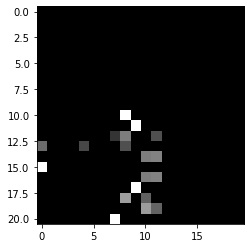

In [16]:
plt.imshow(img.view((21,20)));

## **Initialize model** ##

In [0]:
weights = torch.randn(TOTAL_COLS, CATEGORIES)
bias = torch.zeros(CATEGORIES)

In [0]:
#export
from torch.nn import init
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"
def normalize(x, m, s): return (x-m)/s

In [58]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(5.2017e-05), tensor(1.))

In [0]:
x_train = normalize(x_train, train_mean, train_std)
# NOTE: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [19]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(5.2017e-05), tensor(1.))

In [0]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [21]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(77092, 420, tensor(3))

In [0]:
# num hidden
nh = 50

In [0]:
# simplified kaiming init / he init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [0]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [25]:
# This should be ~ (0,1) (mean,std)...
x_valid.mean(),x_valid.std()

(tensor(0.0003), tensor(0.9918))

In [0]:
def lin(x, w, b): return x@w + b

In [0]:
t = lin(x_valid, w1, b1)

In [28]:
#...so should this, because we used kaiming init, which is designed to do this
t.mean(),t.std()

(tensor(-0.0114), tensor(0.9997))

From pytorch docs: a: the negative slope of the rectifier used after this layer (0 for ReLU by default)

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from He et al: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

In [0]:
import torch.nn

In [30]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 420])

In [0]:
def relu(x): return x.clamp_min(0.) - 0.5

In [32]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.0460), tensor(0.8396))

In [0]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [34]:
%timeit -n 10 _=model(x_valid)

10 loops, best of 3: 7.68 ms per loop


In [0]:
assert model(x_valid).shape==torch.Size([x_valid.shape[0],1])

## **LOSS FUNCTION: MSE** ##

In [59]:
model(x_valid).shape

NameError: ignored

We need squeeze() to get rid of that trailing (,1), in order to use mse. (Of course, mse is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use mse for now to keep things simple.)

In [0]:
#export
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [0]:
preds = model(x_train)

In [39]:
preds.shape

torch.Size([77092, 1])

In [40]:
mse(preds, y_train)

tensor(2.4387)

## **Gradients and backward pass** ##

## Module.forward() ##

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [0]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [0]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [0]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [47]:
%time loss = model(x_train, y_train)

CPU times: user 99.8 ms, sys: 1.33 ms, total: 101 ms
Wall time: 102 ms


In [48]:
%time model.backward()

CPU times: user 211 ms, sys: 826 µs, total: 212 ms
Wall time: 232 ms


## nn.Linear and nn.Module ##

In [0]:
#export
from torch import nn

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [0]:
model = Model(m, nh, 1)

In [52]:
%time loss = model(x_train, y_train)

CPU times: user 87.3 ms, sys: 854 µs, total: 88.2 ms
Wall time: 88.2 ms


In [53]:
%time loss.backward()

CPU times: user 88.1 ms, sys: 16 ms, total: 104 ms
Wall time: 104 ms


## Initial setup ##

In [0]:
#export
import torch.nn.functional as F

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(m, nh, 3)

In [0]:
pred = model(x_train)

In [61]:
y_train[:3]

tensor([0, 0, 1])

In [62]:
loss = F.cross_entropy(pred, y_train) ; loss

tensor(2.2525, grad_fn=<NllLossBackward>)

## **Basic training loop** ##
Basically the training loop repeats over the following steps:


*   get the output of the model on a batch of inputs
*   compare the output to the labels we have and compute a loss
*   calculate the gradients of the loss with respect to every parameter of the model
*   update said parameters with those gradients to make them a little bit better

In [0]:
loss_func = F.cross_entropy

In [0]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [65]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([ 0.5066,  2.2465, -1.1948], grad_fn=<SelectBackward>),
 torch.Size([64, 3]))

In [66]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(4.6879, grad_fn=<NllLossBackward>)

In [67]:
accuracy(preds, yb)

tensor(0.1250)

In [0]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,CATEGORIES)]

In [0]:
# model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,CATEGORIES))
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [71]:
model = Model(layers)
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=420, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [73]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(1.0672, grad_fn=<NllLossBackward>), tensor(0.5156))

## Custom Optimizer ##

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,CATEGORIES))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [78]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.9962, grad_fn=<NllLossBackward>), tensor(0.6111))

## Implemented Optimizers ##

In [0]:
#export
from torch import optim

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,CATEGORIES))
    return model, optim.SGD(model.parameters(), lr=lr)

In [81]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(4.6746, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [83]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.9962, grad_fn=<NllLossBackward>), tensor(0.6111))

In [0]:
assert acc>0.6

## **Dataset and DataLoader** ##
# PyTorch DataLoader #

In [0]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [0]:
# def collate(b):
#     xs,ys = zip(*b)
#     return torch.stack(xs),torch.stack(ys)
# train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
# valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

## Validation ## 

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

## get_dls returns dataloaders for the training and validation sets: ##

In [0]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [63]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

TypeError: ignored

## DataBunch/Learner ##

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [73]:
loss,acc = fit(1, learn)

0 tensor(1.0742) tensor(0.4276)


## Callback Handler / Runner ##

In [0]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [0]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [0]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters>=10: return True

In [81]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [82]:
TrainEvalCallback().name

'train_eval'

In [0]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [0]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [88]:
run.fit(2, learn)

train: [4.12728541872049, tensor(0.4221)]
valid: [1.0778613321443271, tensor(0.4271)]
train: [1.0668441399561563, tensor(0.4255)]
valid: [1.0890202568725134, tensor(0.4261)]


In [89]:
loss,acc = stats.valid_stats.avg_stats
loss,acc

(1.0890202568725134, tensor(0.4261))

In [0]:
#export
from functools import partial

In [0]:
acc_cbf = partial(AvgStatsCallback,accuracy)

In [0]:
run = Runner(cb_funcs=acc_cbf)

In [93]:
run.fit(1, learn)

train: [1.0672569989428216, tensor(0.4262)]
valid: [1.0769033255376252, tensor(0.4275)]


In [94]:
run.avg_stats.valid_stats.avg_stats

[1.0769033255376252, tensor(0.4275)]

## Initialize data ##

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,256
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [98]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [6.979822809111192, tensor(0.4228)]
valid: [1.0750267017294897, tensor(0.4276)]
train: [1.0672969268860582, tensor(0.4254)]
valid: [1.0845981262433118, tensor(0.4276)]
train: [1.0681916573704147, tensor(0.4252)]
valid: [1.076683401358211, tensor(0.4276)]


In [99]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [2.079446067685363, tensor(0.4253)]
valid: [1.0752978723290232, tensor(0.4276)]
train: [1.0669317990193534, tensor(0.4252)]
valid: [1.0742263867214294, tensor(0.4276)]
train: [1.0665995052988637, tensor(0.4253)]
valid: [1.076295938228838, tensor(0.4276)]


In [0]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing ##

In [0]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [0]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [0]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [109]:
f = sched_lin(1,2)
f(0.3)

1.3

In [0]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

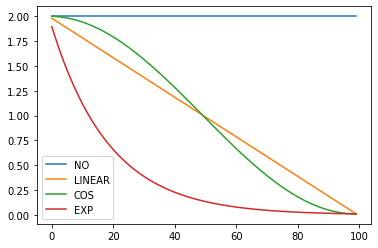

In [111]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [0]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

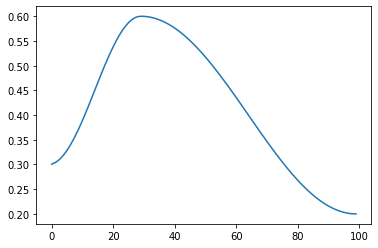

In [114]:
plt.plot(a, [sched(o) for o in p])

In [0]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [0]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [117]:
run.fit(3, learn)

train: [0.7281084917209308, tensor(0.6937)]
valid: [0.6530953641617506, tensor(0.7365)]
train: [0.62342492371128, tensor(0.7452)]
valid: [0.6150407104240979, tensor(0.7487)]
train: [0.5709894509157889, tensor(0.7679)]
valid: [0.592171074350048, tensor(0.7580)]


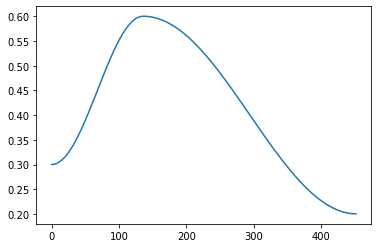

In [118]:
run.recorder.plot_lr()

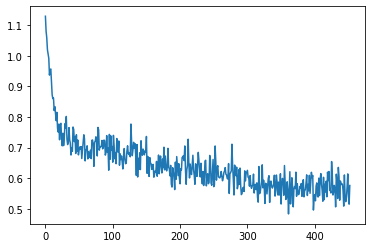

In [119]:
run.recorder.plot_loss()

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

## Early Stopping ##

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

In [0]:
learn = create_learner(get_model, loss_func, data)

In [0]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [0]:
run = Runner(cb_funcs=TestCallback)

In [133]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


In [0]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## LR Finder ##

In [0]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [0]:
learn = create_learner(get_model, loss_func, data)

In [0]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [0]:
run.fit(2, learn)

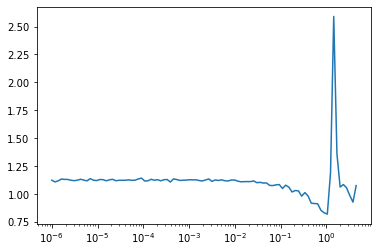

In [144]:
run.recorder.plot(skip_last=5)

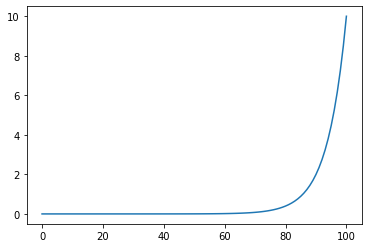

In [145]:
run.recorder.plot_lr()

## ConvNet ##

In [0]:
torch.set_num_threads(2)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [150]:
x_train.mean(),x_train.std()

(tensor(-4.1988e-05), tensor(1.))

In [0]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [0]:
# This one takes the flat vector of size bs x 784 and puts it back as a batch of images of 21 by 20 pixels
def pssp_resize(x): return x.view(-1, 1, WINDOW, AMINO_ACID_LEN)

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(pssp_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #11
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 6
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 3
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [158]:
%time run.fit(1, learn)

train: [1.0463203664128573, tensor(0.4471)]
valid: [0.938811841366271, tensor(0.5414)]
CPU times: user 8.23 s, sys: 186 ms, total: 8.41 s
Wall time: 4.85 s


## **CUDA** ##

In [0]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [0]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [0]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [165]:
%time run.fit(3, learn)

train: [1.0638561313106418, tensor(0.4268, device='cuda:0')]
valid: [1.0382526055957608, tensor(0.4850, device='cuda:0')]
train: [0.8349386427093602, tensor(0.6251, device='cuda:0')]
valid: [0.7305667545916792, tensor(0.6915, device='cuda:0')]
train: [0.7020547487093343, tensor(0.7045, device='cuda:0')]
valid: [0.6585532083876389, tensor(0.7281, device='cuda:0')]
CPU times: user 3.09 s, sys: 356 ms, total: 3.45 s
Wall time: 3.54 s


## Refactor Model ##

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
pssp_view = view_tfm(1, WINDOW, AMINO_ACID_LEN)
cbfs.append(partial(BatchTransformXCallback, pssp_view))

In [0]:
nfs = [8,16,32,32]

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [0]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [178]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [179]:
run.fit(3, learn)

train: [1.0644870738857468, tensor(0.4275, device='cuda:0')]
valid: [1.053933407253224, tensor(0.5265, device='cuda:0')]
train: [0.8653863849361801, tensor(0.6126, device='cuda:0')]
valid: [0.8612220817541844, tensor(0.6289, device='cuda:0')]
train: [0.7254410213608415, tensor(0.6922, device='cuda:0')]
valid: [0.6757546554525655, tensor(0.7164, device='cuda:0')]


## Hooks ##

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [187]:
run.fit(2, learn)

train: [0.9971867014411353, tensor(0.4927, device='cuda:0')]
valid: [1.028580831882803, tensor(0.4538, device='cuda:0')]
train: [0.7348278882698593, tensor(0.6862, device='cuda:0')]
valid: [0.7918953217176568, tensor(0.6613, device='cuda:0')]


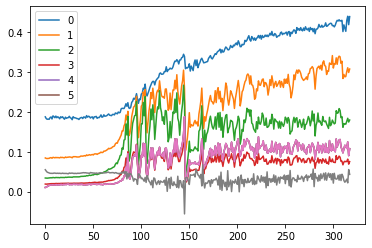

In [188]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

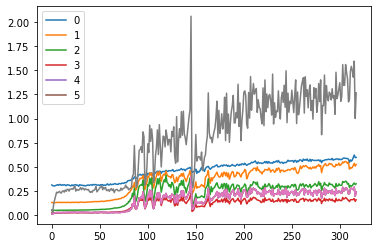

In [189]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

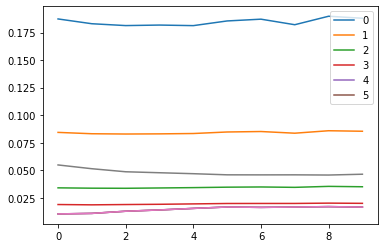

In [190]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

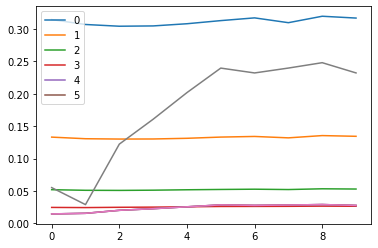

In [191]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [0]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [0]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [196]:
run.fit(1, learn)

train: [1.0632708930563484, tensor(0.4318, device='cuda:0')]
valid: [1.0111490103880847, tensor(0.5599, device='cuda:0')]


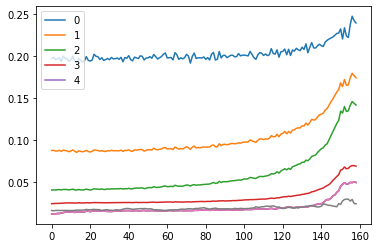

In [197]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

## Hook class ##

In [0]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [201]:
run.fit(1, learn)

train: [1.0665733595898408, tensor(0.4244, device='cuda:0')]
valid: [1.0712400267097681, tensor(0.4276, device='cuda:0')]


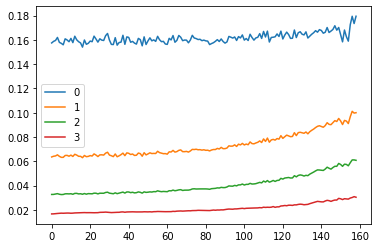

In [202]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [0]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [204]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [205]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [206]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [0]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [209]:
hooks = Hooks(model, append_stats)
hooks

Hooks (8 items)
[<__main__.Hook object at 0x7fc2d1137e48>, <__main__.Hook object at 0x7fc2d1137320>, <__main__.Hook object at 0x7fc2d11374e0>, <__main__.Hook object at 0x7fc2d19e1ef0>, <__main__.Hook object at 0x7fc2d19e1320>, <__main__.Hook object at 0x7fc2d19e1828>, <__main__.Hook object at 0x7fc2d11e3940>, <__main__.Hook object at 0x7fc2d11e30b8>]

In [0]:
hooks.remove()

In [0]:
x,y = next(iter(data.train_dl))
x = pssp_resize(x).cuda()

In [212]:
x.mean(),x.std()

(tensor(-0.0003, device='cuda:0'), tensor(1.0037, device='cuda:0'))

In [213]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2199, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3433, device='cuda:0', grad_fn=<StdBackward0>))

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [215]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4121, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7931, device='cuda:0', grad_fn=<StdBackward0>))

train: [0.9646995432405437, tensor(0.5367, device='cuda:0')]
valid: [0.7918991400783715, tensor(0.6545, device='cuda:0')]
train: [0.7269814393841125, tensor(0.6911, device='cuda:0')]
valid: [0.6825394805100151, tensor(0.7140, device='cuda:0')]


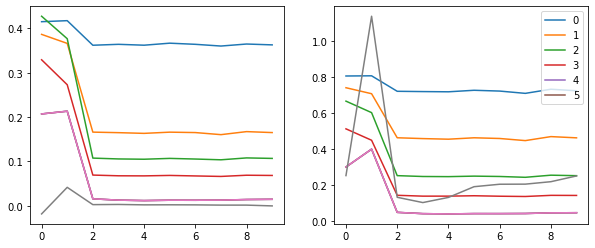

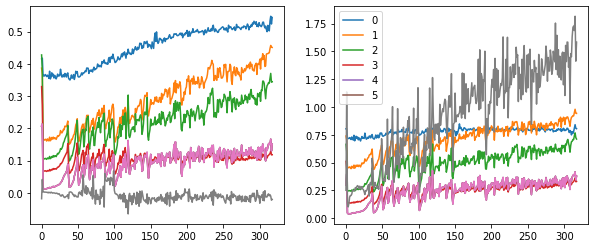

In [216]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [220]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [0.8888158790795413, tensor(0.5848, device='cuda:0')]
valid: [0.7211069333927836, tensor(0.6975, device='cuda:0')]


In [0]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

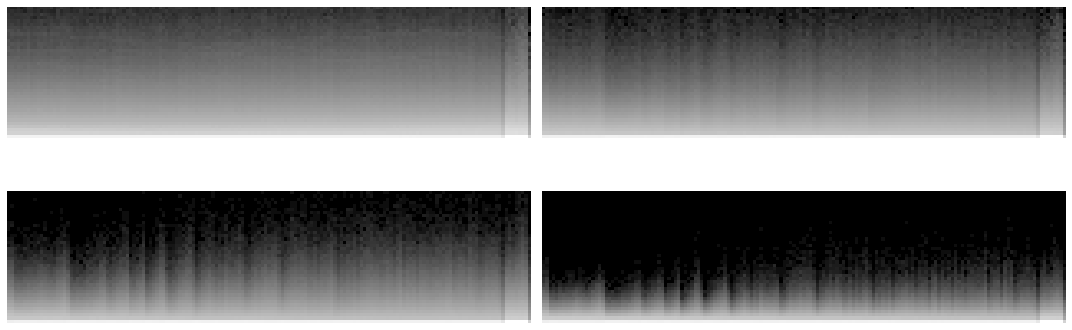

In [222]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

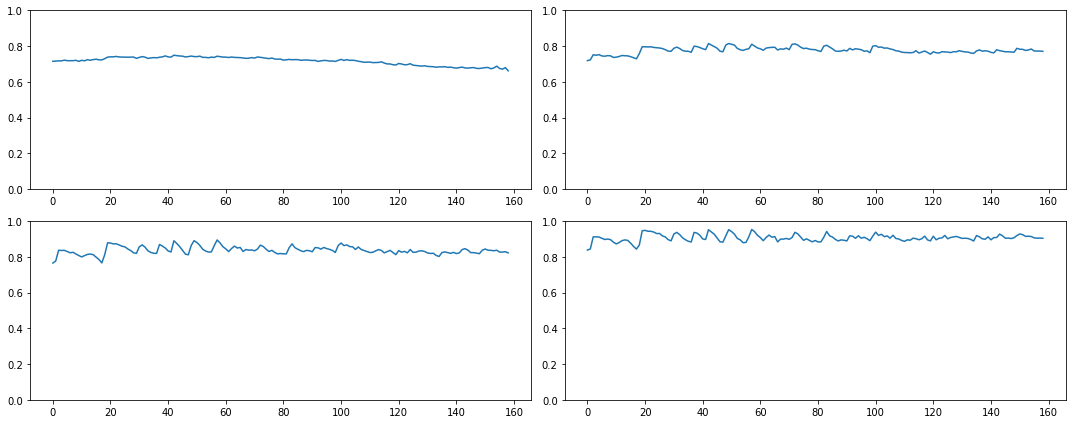

In [224]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Generalized ReLU ##

In [0]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.7478902540957557, tensor(0.6722, device='cuda:0')]
valid: [0.6789932282377555, tensor(0.7204, device='cuda:0')]


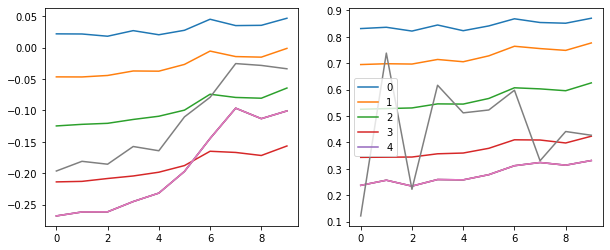

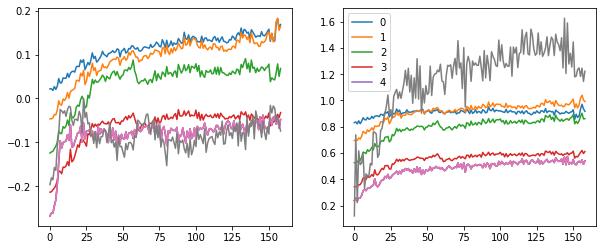

In [228]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

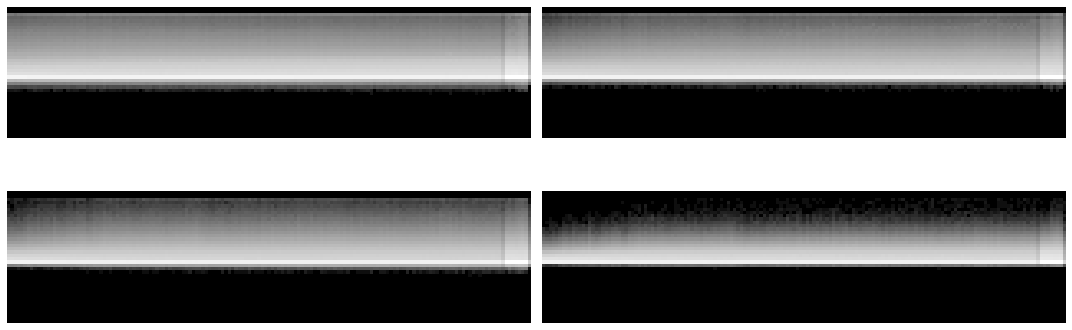

In [229]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

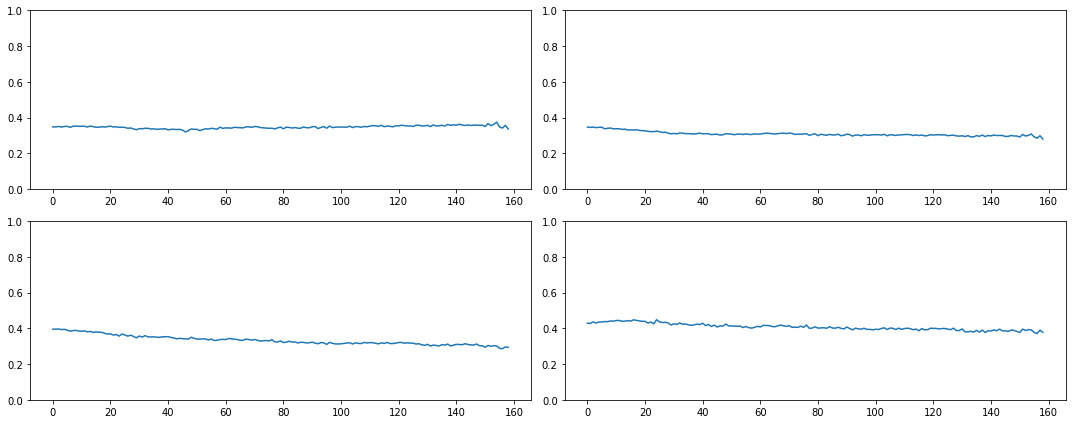

In [231]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [235]:
run.fit(8, learn)

train: [0.9030741070733669, tensor(0.5799, device='cuda:0')]
valid: [0.8238119271119152, tensor(0.6545, device='cuda:0')]
train: [0.734639395948996, tensor(0.6886, device='cuda:0')]
valid: [0.6845589913954246, tensor(0.7129, device='cuda:0')]
train: [0.7013002220561148, tensor(0.7017, device='cuda:0')]
valid: [0.8128849175555631, tensor(0.5979, device='cuda:0')]
train: [0.6634638848713226, tensor(0.7204, device='cuda:0')]
valid: [0.7678703300778571, tensor(0.6754, device='cuda:0')]
train: [0.6236517225360608, tensor(0.7401, device='cuda:0')]
valid: [0.6146108433941556, tensor(0.7418, device='cuda:0')]
train: [0.5753394685894775, tensor(0.7606, device='cuda:0')]
valid: [0.614845639083722, tensor(0.7404, device='cuda:0')]
train: [0.5364447368890417, tensor(0.7762, device='cuda:0')]
valid: [0.607988600116614, tensor(0.7474, device='cuda:0')]
train: [0.505650969377497, tensor(0.7893, device='cuda:0')]
valid: [0.6128564741176773, tensor(0.7495, device='cuda:0')]


In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [307]:
run.fit(8, learn)

train: [0.9117739397408291, tensor(0.5720, device='cuda:0')]
valid: [0.7511897208121827, tensor(0.6882, device='cuda:0')]
train: [0.7603004466254605, tensor(0.6744, device='cuda:0')]
valid: [0.7812071271779394, tensor(0.6670, device='cuda:0')]
train: [0.7240080743624501, tensor(0.6929, device='cuda:0')]
valid: [0.680409505119015, tensor(0.7116, device='cuda:0')]
train: [0.6450653115757796, tensor(0.7308, device='cuda:0')]
valid: [0.7522643548926464, tensor(0.6998, device='cuda:0')]
train: [0.5949521452452914, tensor(0.7502, device='cuda:0')]
valid: [0.6318900644378516, tensor(0.7418, device='cuda:0')]
train: [0.5543481124824885, tensor(0.7665, device='cuda:0')]
valid: [0.6154993156425779, tensor(0.7488, device='cuda:0')]
train: [0.5207490522687179, tensor(0.7802, device='cuda:0')]
valid: [0.6233049157977775, tensor(0.7432, device='cuda:0')]
train: [0.4885449365692938, tensor(0.7932, device='cuda:0')]
valid: [0.6355657390417067, tensor(0.7421, device='cuda:0')]


## ConvNet ##

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
pssp_view = view_tfm(1, WINDOW, AMINO_ACID_LEN)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, pssp_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [239]:
%time run.fit(2, learn)

train: [0.8667476845846521, tensor(0.6006, device='cuda:0')]
valid: [0.7255702621244341, tensor(0.6990, device='cuda:0')]
train: [0.7012246731178332, tensor(0.7045, device='cuda:0')]
valid: [0.6709377599164837, tensor(0.7212, device='cuda:0')]
CPU times: user 2.81 s, sys: 391 ms, total: 3.2 s
Wall time: 3.22 s


## **Batchnorm** ##

In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.7389843972947906, tensor(0.6801, device='cuda:0')]
valid: [1.2746384749279736, tensor(0.5908, device='cuda:0')]


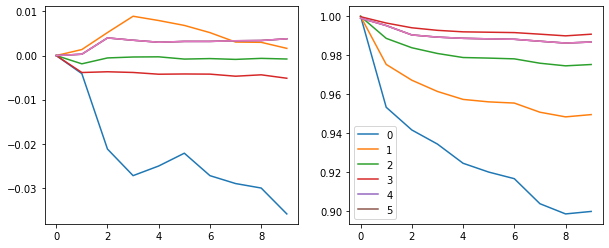

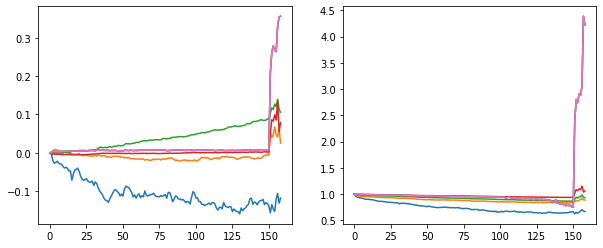

In [244]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [246]:
%time run.fit(3, learn)

train: [0.7603139248398018, tensor(0.6684, device='cuda:0')]
valid: [20.65047288722733, tensor(0.2456, device='cuda:0')]
train: [0.9851949415957557, tensor(0.5121, device='cuda:0')]
valid: [41.30414408698038, tensor(0.4186, device='cuda:0')]
train: [1.0383567685362942, tensor(0.4579, device='cuda:0')]
valid: [1.031963028621896, tensor(0.4824, device='cuda:0')]
CPU times: user 4.82 s, sys: 373 ms, total: 5.19 s
Wall time: 5.21 s


## Builtin batchnorm ##

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [249]:
%time run.fit(3, learn)

train: [0.7502912003677424, tensor(0.6740, device='cuda:0')]
valid: [0.6652166497676293, tensor(0.7258, device='cuda:0')]
train: [0.6346328189857573, tensor(0.7321, device='cuda:0')]
valid: [0.6554920219037248, tensor(0.7325, device='cuda:0')]
train: [0.5949161695603954, tensor(0.7509, device='cuda:0')]
valid: [0.6320062229901221, tensor(0.7407, device='cuda:0')]
CPU times: user 4.29 s, sys: 437 ms, total: 4.73 s
Wall time: 4.75 s


## With scheduler ##

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +[partial(ParamScheduler,'lr', sched)])

In [309]:
run.fit(8, learn)

train: [0.9295783568658227, tensor(0.5621, device='cuda:0')]
valid: [0.7475576559070174, tensor(0.6857, device='cuda:0')]
train: [0.7750315268607637, tensor(0.6647, device='cuda:0')]
valid: [0.7893199378987172, tensor(0.6709, device='cuda:0')]
train: [0.7297437132743995, tensor(0.6890, device='cuda:0')]
valid: [0.6544513511369873, tensor(0.7356, device='cuda:0')]
train: [0.6456086457576662, tensor(0.7298, device='cuda:0')]
valid: [0.6759160314343531, tensor(0.7208, device='cuda:0')]
train: [0.6007620663460541, tensor(0.7500, device='cuda:0')]
valid: [0.6190728993389011, tensor(0.7428, device='cuda:0')]
train: [0.5625644522129404, tensor(0.7649, device='cuda:0')]
valid: [0.619296909834168, tensor(0.7487, device='cuda:0')]
train: [0.5300866679584133, tensor(0.7786, device='cuda:0')]
valid: [0.6116336608459665, tensor(0.7507, device='cuda:0')]
train: [0.49932036357533854, tensor(0.7908, device='cuda:0')]
valid: [0.6222561393881191, tensor(0.7487, device='cuda:0')]


## More norms ##

In [0]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [256]:
%time run.fit(3, learn)

train: [0.7551929127698075, tensor(0.6724, device='cuda:0')]
valid: [0.6671411035678763, tensor(0.7196, device='cuda:0')]
train: [0.6316742495978831, tensor(0.7398, device='cuda:0')]
valid: [0.6316016777207093, tensor(0.7418, device='cuda:0')]
train: [0.5918843313832823, tensor(0.7574, device='cuda:0')]
valid: [0.6050809519267046, tensor(0.7517, device='cuda:0')]
CPU times: user 5.62 s, sys: 270 ms, total: 5.89 s
Wall time: 5.95 s


## Instance Norm ##

In [0]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [260]:
%time run.fit(3, learn)

train: [nan, tensor(0.4254, device='cuda:0')]
valid: [nan, tensor(0.4276, device='cuda:0')]
train: [nan, tensor(0.4254, device='cuda:0')]
valid: [nan, tensor(0.4276, device='cuda:0')]
train: [nan, tensor(0.4254, device='cuda:0')]
valid: [nan, tensor(0.4276, device='cuda:0')]
CPU times: user 5.57 s, sys: 297 ms, total: 5.87 s
Wall time: 5.9 s


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [264]:
%time run.fit(1, learn)

train: [1.107121300686193, tensor(0.3922, device='cuda:0')]
valid: [4.873296877143641, tensor(0.3268, device='cuda:0')]
CPU times: user 2min 42s, sys: 2.33 s, total: 2min 45s
Wall time: 2min 46s


## Running Banch Norm ##

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [268]:
%time run.fit(1, learn)

train: [0.9193192062730244, tensor(0.5905, device='cuda:0')]
valid: [12.569090624571272, tensor(0.6484, device='cuda:0')]
CPU times: user 6min 54s, sys: 4.29 s, total: 6min 58s
Wall time: 7min 1s


## What can we do in a single epoch? ##

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [271]:
%time run.fit(1, learn)

train: [0.7081475096313495, tensor(0.7007, device='cuda:0')]
valid: [0.6766322085291192, tensor(0.7247, device='cuda:0')]
CPU times: user 26.9 s, sys: 258 ms, total: 27.1 s
Wall time: 27.3 s


## Layerwise Sequential Unit Variance (LSUV) ##

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
pssp_view = view_tfm(1, WINDOW, AMINO_ACID_LEN)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, pssp_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [242]:
run.fit(2, learn)

train: [1.0654833470074716, tensor(0.4249, device='cuda:0')]
valid: [1.0460827236460764, tensor(0.4556, device='cuda:0')]
train: [0.8580667011492762, tensor(0.6171, device='cuda:0')]
valid: [0.7725524441795857, tensor(0.6716, device='cuda:0')]


In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [0]:
#export
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = get_batch(data.train_dl, run)

In [0]:
#export
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

In [0]:
mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))

In [248]:
mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

In [0]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.cuda()

In [251]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

0.17743520438671112 0.3178427517414093
0.06828150153160095 0.12698215246200562
0.03235427662730217 0.04977032169699669
0.01700396090745926 0.023984704166650772
0.014024801552295685 0.015353256836533546


In [0]:
#export
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [253]:
for m in mods: print(lsuv_module(m, xb))

(0.3981310725212097, 0.9998525381088257)
(0.3421728312969208, 1.0009163618087769)
(0.3858247995376587, 0.9999839067459106)
(0.4332403838634491, 0.9999889731407166)
(0.46007436513900757, 0.9999792575836182)


In [254]:
%time run.fit(2, learn)

train: [0.8284670730263841, tensor(0.6261, device='cuda:0')]
valid: [0.6868873875660242, tensor(0.7112, device='cuda:0')]
train: [0.6838546497204638, tensor(0.7102, device='cuda:0')]
valid: [0.64522545477346, tensor(0.7329, device='cuda:0')]
CPU times: user 2.64 s, sys: 414 ms, total: 3.06 s
Wall time: 3.05 s


## Data Block API Foundations ##

In [0]:
#noexport
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [0]:
#noexport
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [0]:
#noexport
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [0]:
#noexport
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [0]:
#noexport
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [0]:
#noexport
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [0]:
#noexport
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [0]:
#noexport
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [0]:
#noexport
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [0]:
#noexport
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [0]:
#noexport
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

In [0]:
#noexport
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [0]:
#noexport
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [0]:
#noexport
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [0]:
#noexport
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
#noexport
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [0]:
#noexport
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [0]:
#noexport
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
#noexport
def model_summary(run, learn, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

## **Optimizer tweaks** ##

In [0]:
#noexport
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [0]:
#noexport
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [0]:
#noexport
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [0]:
#noexport
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [0]:
#noexport
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [0]:
#noexport
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [0]:
#noexport 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [0]:
#noexport
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [0]:
#noexport
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [0]:
#noexport
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [0]:
#noexport
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

In [0]:
#noexport
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [0]:
#noexport
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [0]:
#noexport
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [0]:
#noexport
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [0]:
#noexport
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [0]:
#noexport
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

## Replace Runner with Learner ##

In [0]:
#noexport
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                if not self.do_begin_epoch(epoch): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [0]:
#noexport
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats)

In [0]:
#noexport
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

## Adding progress bars to Learner ##

In [0]:
#noexport
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

In [0]:
#noexport 
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

In [0]:
#noexport 
class ProgressCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

## Data augmentation ##

In [0]:
#noexport
make_rgb._order=0

In [0]:
#export
import random

In [0]:
#noexport
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

In [0]:
#noexport
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [0]:
#noexport
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [0]:
#noexport
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [0]:
#noexport
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to squish
        if   w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else:                     size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

In [0]:
#noexport
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [0]:
#noexport
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [0]:
#noexport
def uniform(a,b): return a + (b-a) * random.random()

In [0]:
#noexport
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [0]:
#noexport
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

## Mixup / Label smoothing ##

In [0]:
#noexport
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)

In [0]:
#noexport
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [0]:
#noexport
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [0]:
#noexport
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

## Training in mixed precision ##

In [0]:
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir ./apex

In [0]:
#noexport 
import apex.fp16_utils as fp16

In [0]:
#noexport 
def get_master(opt, flat_master=False):
    model_pgs = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_pgs = []
        for pg in model_pgs:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = torch.nn.Parameter(mp, requires_grad=True)
            if mp.grad is None: mp.grad = mp.new(*mp.size())
            master_pgs.append([mp])
    else:
        master_pgs = [[param.clone().float().detach() for param in pg] for pg in model_pgs]
        for pg in master_pgs:
            for param in pg: param.requires_grad_(True)
    return model_pgs, master_pgs

In [0]:
#noexport 
def to_master_grads(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.model_grads_to_master_grads(model_params, master_params, flat_master=flat_master)

In [0]:
#noexport 
def to_model_params(model_pgs, master_pgs, flat_master:bool=False)->None:
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.master_params_to_model_params(model_params, master_params, flat_master=flat_master)

In [0]:
#export 
def test_overflow(x):
    s = float(x.float().sum())
    return (s == float('inf') or s == float('-inf') or s != s)

In [0]:
#export 
def grad_overflow(param_groups):
    for group in param_groups:
        for p in group:
            if p.grad is not None:
                s = float(p.grad.data.float().sum())
                if s == float('inf') or s == float('-inf') or s != s: return True
    return False

In [7]:
#noexport 
class MixedPrecision(Callback):
    _order = 99
    def __init__(self, loss_scale=512, flat_master=False, dynamic=True, max_loss_scale=2.**24, div_factor=2.,
                 scale_wait=500):
        assert torch.backends.cudnn.enabled, "Mixed precision training requires cudnn."
        self.flat_master,self.dynamic,self.max_loss_scale = flat_master,dynamic,max_loss_scale
        self.div_factor,self.scale_wait = div_factor,scale_wait
        self.loss_scale = max_loss_scale if dynamic else loss_scale

    def begin_fit(self):
        self.run.model = fp16.convert_network(self.model, dtype=torch.float16)
        self.model_pgs, self.master_pgs = get_master(self.opt, self.flat_master)
        #Changes the optimizer so that the optimization step is done in FP32.
        self.run.opt.param_groups = self.master_pgs #Put those param groups inside our runner.
        if self.dynamic: self.count = 0

    def begin_batch(self): self.run.xb = self.run.xb.half() #Put the inputs to half precision
    def after_pred(self):  self.run.pred = self.run.pred.float() #Compute the loss in FP32
    def after_loss(self):  
        if self.in_train: self.run.loss *= self.loss_scale #Loss scaling to avoid gradient underflow

    def after_backward(self):
        #First, check for an overflow
        if self.dynamic and grad_overflow(self.model_pgs):
            #Divide the loss scale by div_factor, zero the grad (after_step will be skipped)
            self.loss_scale /= self.div_factor
            self.model.zero_grad()
            return True #skip step and zero_grad
        #Copy the gradients to master and unscale
        to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None: param.grad.div_(self.loss_scale)
        #Check if it's been long enough without overflow
        if self.dynamic:
            self.count += 1
            if self.count == self.scale_wait:
                self.count = 0
                self.loss_scale *= self.div_factor

    def after_step(self):
        #Zero the gradients of the model since the optimizer is disconnected.
        self.model.zero_grad()
        #Update the params from master to model.
        to_model_params(self.model_pgs, self.master_pgs, self.flat_master)

NameError: ignored

## **XResNet** ##

In [8]:
#noexport
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

NameError: ignored

In [9]:
#noexport
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

NameError: ignored

In [0]:
#noexport
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [10]:
#noexport
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

NameError: ignored

In [0]:
#noexport
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [0]:
#noexport
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

In [0]:
#noexport
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [0]:
#noexport
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [0]:
#noexport
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

## Serializing the model ##

In [0]:
#noexport
def random_splitter(fn, p_valid): return random.random() < p_valid

In [0]:
#noexport
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
#noexport
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [17]:
#noexport
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

NameError: ignored

In [0]:
#noexport
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

## Create module ##

In [0]:
# !pip3 install fire

In [1]:
# ! rm -rf thesis_project
# ! git clone https://github.com/Ghost-8D/thesis_project/

Cloning into 'thesis_project'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (741/741), done.
remote: Compressing objects: 100% (626/626), done.
remote: Total 741 (delta 130), reused 703 (delta 114), pack-reused 0
Receiving objects: 100% (741/741), 8.06 MiB | 1.76 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Checking out files: 100% (701/701), done.


In [0]:
# !rm -rf exp # delete exported modules

In [0]:
notebook2script_path = './thesis_project/PSSP_Playground/notebook2script.py'
import_modules_path = './thesis_project/PSSP_Playground/NN_from_scratch.ipynb'

In [0]:
!mv "$notebook2script_path" ./
!mv "$import_modules_path" ./

In [5]:
!python notebook2script.py NN_from_scratch.ipynb

Converted NN_from_scratch.ipynb to exp/nb_NN.py


## Export ##
Here's a handy way to export our module without needing to update the file name - after we define this, we can just use nb_auto_export() 

In [0]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [24]:
nb_auto_export()

<IPython.core.display.Javascript object>

In [21]:
!head ./exp/nb_NN.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/NN_from_scratch.ipynb

import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__


## Import modules ##

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from exp.nb_NN import *

In [17]:
# Set seed
torch.manual_seed(42)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
pssp_view = view_tfm(1, WINDOW, AMINO_ACID_LEN)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, pssp_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +[partial(ParamScheduler,'lr', sched)])

In [311]:
xb,yb = get_batch(data.train_dl, run)

AttributeError: ignored

In [293]:
mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))
mods

[]

In [0]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.cuda()

In [0]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

In [0]:
for m in mods: print(lsuv_module(m, xb))

In [298]:
%time run.fit(4, learn)

train: [0.5634503154510195, tensor(0.7627, device='cuda:0')]
valid: [0.8100822407909178, tensor(0.6773, device='cuda:0')]
train: [0.6171389074904011, tensor(0.7400, device='cuda:0')]
valid: [0.6557044433392784, tensor(0.7345, device='cuda:0')]
train: [0.5284486088861361, tensor(0.7787, device='cuda:0')]
valid: [0.6640087749948552, tensor(0.7424, device='cuda:0')]
train: [0.46848894826959997, tensor(0.8014, device='cuda:0')]
valid: [0.673785922065784, tensor(0.7451, device='cuda:0')]
CPU times: user 4.9 s, sys: 839 ms, total: 5.74 s
Wall time: 5.71 s
